In [1]:
push!(LOAD_PATH, pwd()*"/..")
import_path = "/Users/julian/Harvard/research/nowak/indirect_rec/src"
push!(LOAD_PATH, import_path)
using LightGraphs, Epidemics, GraphGeneration,IM
using GraphGeneration
using NLsolve
using PyPlot, Distributions
using DegreeDistribution
using StatsBase
using GraphCreation
using Clustering
using DataAnalysis
using TwoLevelGraphs


Use "Dict(a=>b for (a,b) in c)" instead.


In [2]:
N = 10000
k = 10
C = 0.5
d = Binomial(k,1) 

c_r = 0.3
y_n = 0.1

n_n = Int(N*y_n)#y_n*N
beta = get_beta(N,c_r,n_n)#4.0/(c_r*n_n)
alpha = get_alpha(N,c_r,n_n)#(N*beta)/n_n

# alpha,beta = 0.0,0.0
# beta = 0.0
# alpha = 10


println(alpha," ", beta)
im_normal = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
fixation_threshold = (N-2)/N
carry_by_node_information = false
graph_model = true
in_parallel = true

#:erdos_renyi,:watts_strogatz,:gamma_fb,:rand_clust

# G = create_graph(N,k,:erdos_renyi,C,deg_distr=d)
# H = create_graph(N,k,:rand_clust,C,deg_distr=d)
K = create_graph(N,k,:watts_strogatz,C,deg_distr=d)
# GC = regular_clustering_graph(N,k,C)
R = LightGraphs.random_regular_graph(N,k)
m = 14 #0.5: m=14,l=9,r=1 $ 0.3: m = 10, l = 7, r = 3
l = 9
r = k -l
t = TwoLevel(Int(ceil(N/m)*m),m,l,r)
# l = 9
# m = 20
# t = TwoLevel(N,m,l,k-r)
println(t.N)
T = generate_regular_two_level_graph(t)
# println(mean(local_clustering_coefficient(G)))
# println(mean(local_clustering_coefficient(H)))
println(mean(local_clustering_coefficient(K)))
println(mean(local_clustering_coefficient(R)))
println(mean(local_clustering_coefficient(T)))
# println(mean(local_clustering_coefficient(GC)))

0.13333333333333333 0.013333333333333334
10010
0.5022783705183705
0.0010466666666666667
0.5073326673326671


# The effect of clustering gets stronger with small $k$ and with large $N$.

It might have something to do with how the pair counts are estimated. For example, why do II pairs sometimes rise while IS pairs go extinct? Sometimes the pair count should be higher than the model suggests (i.e. mis = 0, mii large should give a lot of overlap pairs). How do I avoid impossible counts?

Somehow the algorithm seems to produce to many II pairs for large N

In [69]:
num_trials = 1000
# println(C)
# Profile.clear()
#Profile.print()
@time yy,pp,edge_counts = Clustering.get_p_reach_well_mixed_with_clustering(N,k,C,alpha,beta,num_trials,fixation_threshold);    
@time yyrc,pprc,edge_countsrc = Clustering.get_p_reach_well_mixed_with_clustering(N,k,(k-1)/N,alpha,beta,num_trials,fixation_threshold);    
# println(C)
im = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,k,N) , x -> 1 + beta)
yyr = logspace(log10(1/N),0,500)
@time ppr = P_reach_fast(im,N,1.0/N,yyr,true);

 54.916471 seconds (1.16 G allocations: 27.070 GB, 25.08% gc time)
  6.723623 seconds (153.61 M allocations: 3.580 GB, 25.49% gc time)
  0.014870 seconds (82.84 k allocations: 3.779 MB, 58.24% gc time)


In [70]:
num_trials_local_sim = 1000
# graph_fn = () -> create_graph(N,k,:erdos_renyi,C,deg_distr=d)
graph_fn = () -> K #create_graph(N,k,:watts_strogatz,C,deg_distr=d)
graph_data = C

graph_information = GraphInformation(graph_fn,Graph(),carry_by_node_information,graph_data)

@time runssim = run_epidemics_parallel(num_trials_local_sim,() -> run_epidemic_graph_gillespie(N,im_normal,graph_information,fixation_threshold),in_parallel);
yysim,ppsim = get_p_reach(runssim)
yysim /= N

num_points = 200
@time yytl,pptl,s_eff_two_level = get_p_reach_theory(t,alpha,beta,N,true,num_points)


LoadError: InterruptException:
 in compute_rate(::PayloadGraph.Graph{Int64}, ::Int64, ::IM.InfectionModel) at /Users/julian/Dropbox/ubuntu_home/Harvard/research/desai/population/src/SIS.jl:354
 in update_nodes_and_rates(::PayloadGraph.Graph{Int64}, ::Int64, ::Array{Float64,1}, ::IM.InfectionModel) at /Users/julian/Dropbox/ubuntu_home/Harvard/research/desai/population/src/SIS.jl:376
 in update_graph_gillespie(::PayloadGraph.Graph{Int64}, ::IM.InfectionModel, ::Array{Float64,1}) at /Users/julian/Dropbox/ubuntu_home/Harvard/research/desai/population/src/SIS.jl:383
 in run_epidemic_graph_gillespie(::Int64, ::IM.InfectionModel, ::Epidemics.GraphInformation, ::Float64) at /Users/julian/Dropbox/ubuntu_home/Harvard/research/desai/population/src/Epidemics.jl:215
 in (::Epidemics.##9#10{##111#112})(::Int64) at /Users/julian/Dropbox/ubuntu_home/Harvard/research/desai/population/src/Epidemics.jl:401
 in macro expansion at ./asyncmap.jl:63 [inlined]
 in (::Base.##755#757{Base.AsyncCollector,Base.AsyncCollectorState})() at ./task.jl:360

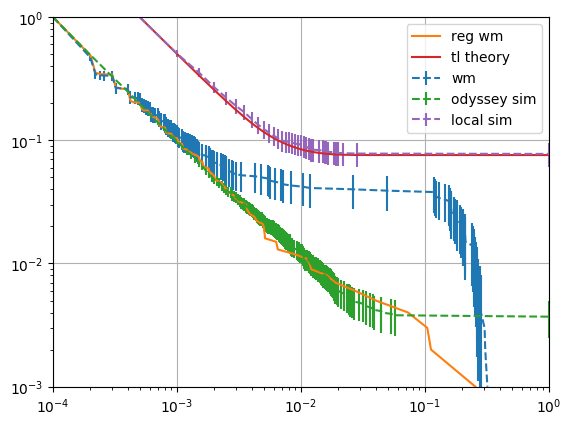

PyObject <matplotlib.legend.Legend object at 0x328950f90>

In [74]:
# loglog(yy/N,pp)
errorbars = 2*(pp.*(1-pp)/num_trials).^0.5
plt[:errorbar](yy,pp,linestyle="--",yerr=errorbars,label="wm")#,label=simulation_labels[i])
# loglog([],[])

loglog(yyrc,pprc,label="reg wm")
# loglog(yyr,ppr,label="reg th.")


errorbars_c = 2*(ppc.*(1-ppc)/runs.num_trials).^0.5
plt[:errorbar](yyc,ppc,linestyle="--",yerr=errorbars_c,label="odyssey sim")#,label=simulation_labels[i])
# loglog(yyc,ppc)

loglog(yytl,pptl,label="tl theory")

errorbars_sim = 2*(ppsim.*(1-ppsim)/num_trials_local_sim).^0.5
plt[:errorbar](yysim,ppsim,linestyle="--",yerr=errorbars_sim,label="local sim")#,label=simulation_labels[i])
# loglog(yysim,ppsim)
xlim([1/N,1])
ylim([1e-3,1])
# ylim([1/num_trials,1])
grid()
legend()

In [71]:
data_dir_path = "../../data/"  #"/mnt/D/windows/MIT/classes/6/338/project/data/"
filenames = split(readstring(`ls $data_dir_path`));
filenames[1:12]
path = data_dir_path*filenames[end-6]
params,yyc,ppc,epidemic_params,k_c,graph_information,graph_type,runs,num_trials_sim = load_p_reach_data(path);
filenames[end-10:end]
epidemic_params.N,k_c,graph_information.data,epidemic_params.alpha,epidemic_params.beta

(10000,10,0.1,0.13333333333333333,0.013333333333333334)

In [268]:
runs.num_trials

10000

In [261]:
function get_expected_clustering(k,N,ki,m)
    ke = k - ki 
    C_i = (ki-1)/(m-2)
    C_e = (N-2*m)*(ke-1)/(N-m)^2 + (m/(N-m))*(ki/(m-1))
    return (ki*(ki-1)*C_i + ke*(ke-1)*C_e )/ (k*(k-1))
end

function get_expected_clustering(t::TwoLevel)
    return get_expected_clustering(t.l + t.r,t.N,t.l,t.m)
end

function g!(x, fvec)
    fvec[1] = get_c_fn(x[1],x[2]) - C
#     fvec[2] = sum((x - round(x)).^2)
end


g! (generic function with 1 method)

In [205]:
N = 24*100
m = 24 #m=14,l=9,r=1
k = 10
l = 9
r = k -l
t1 = TwoLevel(Int(ceil(N/m)*m),m,l,r)
println(get_expected_clustering(t1))
T = generate_regular_two_level_graph(t1)
println(mean(local_clustering_coefficient(T)))

0.29090909090909095
0.267861111111111


In [155]:
using NLsolve

C = 0.5
N = 400
k = 10

get_c_fn(ki,m) = get_expected_clustering(k,N,ki,m)


sol = nlsolve(g!, [k/2,N/2])


Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [5.0,200.0]
 * Zero: [10.4766,22.9165]
 * Inf-norm of residuals: 0.000000
 * Iterations: 12
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 13
 * Jacobian Calls (df/dx): 8

In [145]:
solution = round(sol.zero)
ki = Int(solution[1])
m = Int(solution[2])
t1 = TwoLevel(Int(ceil(N/m)*m),m,ki,k-ki)
println(get_expected_clustering(t1))
T = generate_regular_two_level_graph(t1)
println(mean(local_clustering_coefficient(T)))

0.45


LoadError: InterruptException:

In [206]:
using JuMP
using CoinOptServices

function get_optimal_tl_params(N,k,C)

    mod = Model(solver=OsilBonminSolver())
    @variable(mod,ki_v, Int)
    @variable(mod,m_vh, Int)

    @NLobjective(mod,Min,(C - (ki_v*(ki_v-1)*(ki_v-1)/(2*m_vh-2) + (k-ki_v)*((k-ki_v)-1)*((N-2*2*m_vh)*((k-ki_v)-1)/(N-2*m_vh)^2 + (2*m_vh/(N-2*m_vh))*(ki_v/(2*m_vh-1))) )/ (k*(k-1)))^2)    
    @NLconstraint(mod,ki_v <= 2*m_vh-1)
    @NLconstraint(mod,1 <= ki_v <= k-1)
    @NLconstraint(mod,1 <= 2*m_vh <= N/2)
    # @NLconstraint(mod,ki_v*m_v/2 == round(ki_v*m_v/2))

    # Solve problem using MIP solver
    status = solve(mod)

    println("Objective is: ", getobjectivevalue(mod))
    println("Solution is:")
    println("ki = ",getvalue(ki_v))
    println("m = ",2*getvalue(m_vh))


    ki = Int(getvalue(ki_v))
    m = Int(2*getvalue(m_vh) )
    t1 = TwoLevel(Int(ceil(N/m)*m),m,ki,k-ki)
    println(get_expected_clustering(t1))
    T = generate_regular_two_level_graph(t1)
    println(mean(local_clustering_coefficient(T)))
    return t1
end


get_optimal_tl_params (generic function with 1 method)

In [220]:
get_optimal_tl_params(24*100,10,0.1*1.0)



Optimization Services Solver
Main Authors: Horand Gassmann, Jun Ma, and Kipp Martin
Distributed under the Eclipse Public License
OS Version:  2.9.3
Build Date: Oct 24 2016




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Objective is: 6.720655683212513e-8
Solution is:
ki = 7.0
m = 30.0
0.10025924227439237
0.08694444444444427


TwoLevelGraphs.TwoLevel(Number[0,0,0,0,0,0,0,0,0,0  …  0,0,0,0,0,0,0,0,0,0],2400,30,80,0,3,7)

## Plot individual time series

In [26]:
function get_individual_arrays(ecs::Array{Clustering.EdgeCounts,1})
    len = length(ecs)
    miis = zeros(len)
    miss = zeros(len)
    msss = zeros(len)
    ns = zeros(len)
    for i = 1:len
        miis[i] = ecs[i].mii
        miss[i] = ecs[i].mis
        msss[i] = ecs[i].mss
        ns[i] = Clustering.get_num_infecteds(ecs[i])
    end
    return miis,miss,msss,ns
end

function get_z_arrays(ecs::Array{EdgeCounts,1},C,central_infected,attached_infected)
    len = length(ecs)
    z_a_arr = zeros(len)
    z_a_b_arr = zeros(len)
    z_a_b_mean_arr = zeros(len)
    for i = 1:len
        ms = ecs[i]
        if ms.mis > 0
            z_a_arr[i] = get_z_a(ms,central_infected)
            z_a_b_arr[i] = get_z_a_b(ms,central_infected,attached_infected)
            z_a_b_mean_arr[i] = get_z_a_b_mean(C,ms,central_infected,attached_infected)
        end
    end
    return z_a_arr,z_a_b_arr,z_a_b_mean_arr
end

function get_infection_size(ecs::Array{Clustering.EdgeCounts,1})
    len = length(ecs)
    size_curr = 0
    for i = 1:len
        size_curr += Clustering.get_num_infecteds(ecs[i])
    end
    size_curr *= 0.1
    return size_curr
end

function get_max_reach(ecs::Array{Clustering.EdgeCounts,1})
    max_curr = -1.0
    for i = 1:length(ecs)
        max_curr = max(Clustering.get_num_infecteds(ecs[i]),max_curr)
    end
    return max_curr
end
    

get_max_reach (generic function with 1 method)

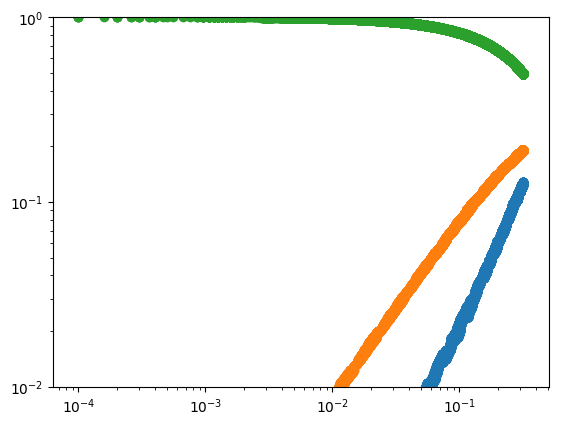

(0.01,1.0)

In [77]:

loglog([],[])
scatter(ns/Clustering.get_N(ms),miis/m)
scatter(ns/Clustering.get_N(ms),miss/m)
scatter(ns/Clustering.get_N(ms),msss/m)
ylim([1e-2,1])

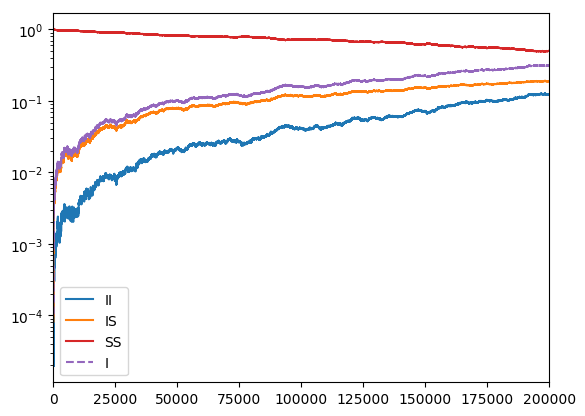

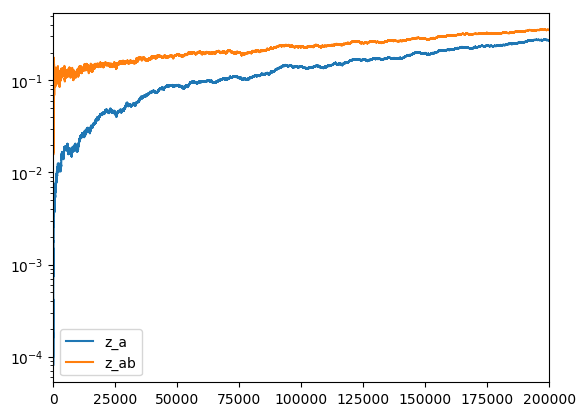

PyObject <matplotlib.legend.Legend object at 0x327cb7c90>

In [76]:

idx = 166
C = 0.5
ecs = edge_counts[idx]

xlim_ = length(ecs)#200
ms = ecs[1]
m = ms.m
miis,miss,msss,ns = get_individual_arrays(ecs)
z_a,z_ab,z_abm = get_z_arrays(ecs,C,false,true)
#when attached infected is false, the time series become the same
xlim([0,xlim_])
plot(miis/m,label="II")
plot(miss/m,label="IS")
semilogy([],[])
plot(msss/m,label="SS")

# plot(z_a,label="z_a")
# plot(z_ab,label="z_ab")
# plot(msss+2*miss+miis,label="Tot")
plot(ns/Clustering.get_N(ms),"--",label="I")
legend(loc="best")
# ylim([1e-2,2e-2])
# ylim([0.5/m,1.1])
# xlim([8100,8120])
figure()
xlim([0,xlim_])
plot(z_a,label="z_a")
plot(z_ab,label="z_ab")
semilogy([],[])
# plot(z_abm,label="z_abm")
legend()

In [75]:
for i = 1:1000
    if length(edge_counts[i]) > 100
        println("$i: $(get_max_reach(edge_counts[i]))")
#         println("$i: $(length(edge_counts[i]))")
    end
    if edge_counts[i][end-1].mii == 2
        println("here: $i")
    end
#     if (get_max_reach(edge_counts[i])) > 1000
#         println("$i: $(get_max_reach(edge_counts[i]))")
#     end
end

4: 9.4
here: 4
11: 21.2
here: 13
here: 20
here: 31
here: 33
here: 40
48: 28.0
here: 55
here: 60
here: 63
here: 64
here: 68
here: 70
here: 71
here: 74
here: 86
88: 2821.0
89: 14.6
here: 91
here: 94
here: 97
here: 100
102: 2111.0
109: 14.6
124: 118.0
here: 130
here: 149
here: 150
154: 30.0
164: 20.0
here: 164
166: 3183.6
180: 14.0
here: 184
here: 188
here: 190
here: 191
195: 2036.6
here: 203
here: 204
207: 1297.4
here: 208
here: 209
here: 220
here: 244
249: 1798.0
251: 19.6
here: 251
here: 254
here: 259
261: 22.6
here: 261
267: 2441.6
269: 56.4
271: 23.4
273: 25.0
here: 273
here: 293
here: 298
301: 9.6
307: 26.4
here: 312
324: 47.8
328: 2608.0
here: 331
336: 21.0
339: 1578.0
here: 351
here: 353
here: 355
here: 356
here: 359
360: 13.2
here: 365
389: 1949.0
391: 2554.0
394: 3058.0
396: 11.4
here: 396
397: 2011.0
here: 398
400: 495.8
401: 12.2
here: 404
here: 412
416: 1623.2
420: 103.0
422: 2462.0
here: 424
here: 425
429: 19.0
here: 429
430: 18.6
435: 2609.0
here: 446
here: 450
here: 453
he

## Why do we get steady state behavior?

## Where does the factor of $k$ go?

## Posterior distribution over k

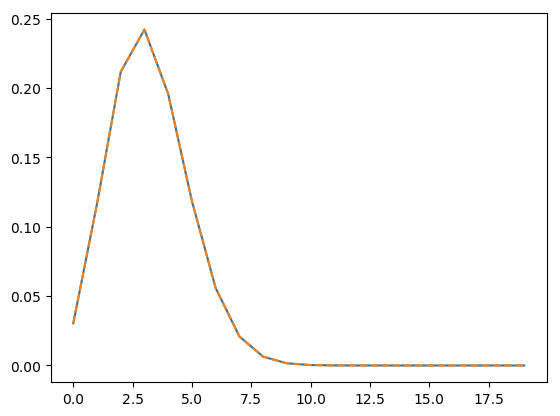

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x326409e90>

In [41]:
k = 20
z_a = 0.01
z_ab = 0.8
C = 0.2
bins = collect(0:k-1)
plot(bins,[Clustering.prior_ki(_,k-1,z_a,z_ab,C) for _ in bins])
plot(bins,[Clustering.prior_ki_fast(_,k-1,z_a,z_ab,C) for _ in bins],"--")

In [62]:
alpha,beta = 0.06,0.66
k = 6
N = 400
# n = 50
C = 0.5
ms = EdgeCounts(Int(N*k/2),0,N*k,k)
num_trials = 10000
central_infected = false 
attached_infected = true 
z_a_b_m = get_z_a_b_mean(C,ms,central_infected,attached_infected)


@time kis = [Clustering.draw_k_i(ms,k,C,central_infected,attached_infected)[1] for i = 1:num_trials]
@time kisp = [Clustering.sample_posterior_k_i(C,ms,central_infected,attached_infected,alpha,beta)[1] for i = 1:num_trials]
@time approx = rand(Binomial(k-1,z_a_b_m),num_trials);
ms
z_a = get_z_a(ms,central_infected)
z_ab = get_z_a_b(ms,central_infected,attached_infected)
println("z_a: $(z_a), z_ab: $(z_ab)")
Clustering.get_pair_count(ms,central_infected,attached_infected)
Clustering.get_pair_count_approximation(ms,central_infected,attached_infected)

  0.027556 seconds (133.27 k allocations: 2.636 MB)
  0.051836 seconds (673.27 k allocations: 14.385 MB, 12.57% gc time)
  0.000420 seconds (7 allocations: 78.391 KB)
z_a: 0.5, z_ab: 0.3333333333333333


600.0

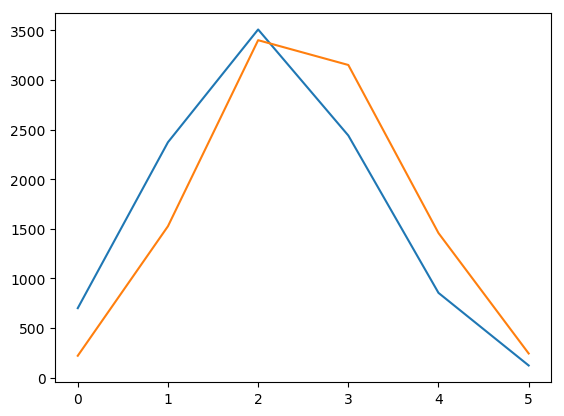

z_a: 0.5, z_ab: 0.3333333333333333


In [56]:
figure()
bins = collect(0:k-1)
# PyPlot.plt[:hist](kis,bins=bins,alpha=0.5,label="prior")
# PyPlot.plt[:hist](kisp,bins=bins,alpha=0.5,label="post")
plot(counts(kis))
plot(counts(kisp))
# plot(counts(approx),"--")
legend()

